<div class="head0">
    <div class="head0__name">
        TMP file
    </div>
    <div class="head0__note">
        Some examples and tests are here.
    </div>
</div>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from fpcross import ij, Grid, Func, Solver, Model, Check
from fpcross import config

ij()

Start | 12:37PM MSK on Jan 17, 2020 | python 3.7.4    |
-------------------------------------------------------


<div class="head1">
    <div class="head1__name">
        Func
    </div>
    <div class="head1__note"></div>
</div>

In [4]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ]) + np.exp(-x[1, ])

GR = Grid(d=2, n=[2, 2], l=[
    [-1., 1.],
    [-1., 1.],
])

FN = Func(GR)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function  
Format           : 2D, NP
--> Time (sec.)  |       
Prep             : 3.59e-04 
Calc             : 6.80e-04 
Comp (average)   : 9.76e-05 
Func (average)   : 8.86e-05 
--> Test         |       
Random points    :      Yes   
Number of points :      100   
Error (max)      : 1.66e+02 
Error (mean)     : 5.05e+00 
Error (min)      : 1.53e-01 
-->Test (uni.gr.)|
Error (max)      : 6e+02   


In [ ]:
GR2 = GR.copy(n=[3, 3])
F2 = FN.comp_grid(GR2)

In [5]:
FN2 = FN.copy(SG=GR2, is_init=True)
FN2.init(func, opts={'Y0': F2})
FN2.prep()
FN2.calc()
FN2.info(n_test=100)

e = FN2.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function  
Format           : 2D, NP
--> Time (sec.)  |       
Prep             : 2.49e-04 
Calc             : 4.86e-04 
Comp (average)   : 1.24e-04 
Func (average)   : 2.72e-05 
--> Test         |       
Random points    :      Yes   
Number of points :      100   
Error (max)      : 5.90e+01 
Error (mean)     : 1.88e+00 
Error (min)      : 2.81e-02 
-->Test (uni.gr.)|
Error (max)      : 4e+02   


<div class="head1">
    <div class="head1__name">
        Plots
    </div>
    <div class="head1__note"></div>
</div>

In [6]:
x = np.arange(20)
y = [
    2. + 10./(1 + x**2),
    -8./(1 + x**3),
    6. * np.sin(x/10),
    np.cos(x/5),
    -2. - np.exp(1./(x+1))
]

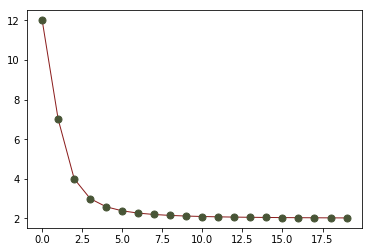

In [7]:
opt = {
    'linewidth': 1,
    'linestyle': '-',
    'color': '#8b1d1d',
    'marker': 'o',
    'markersize': 7,
    'markerfacecolor': '#485536',
    'markeredgewidth': 1,
    'markeredgecolor': '#485536',
}
plt.plot(x, y[0], **opt)
plt.show()

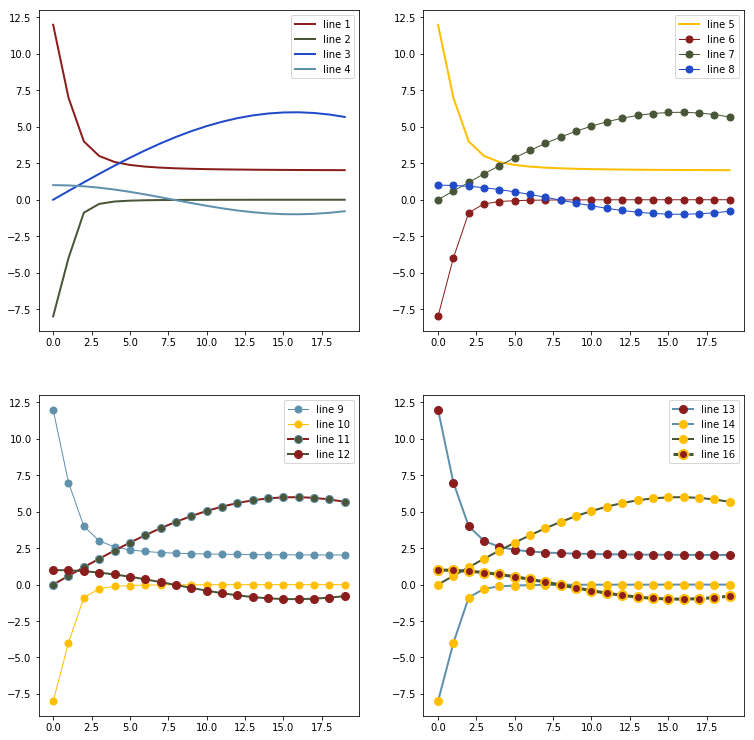

In [8]:
conf = config['opts']['plot']
fig = plt.figure(**conf['fig']['base_2_2'])
gs = mpl.gridspec.GridSpec(**conf['grid']['base_2_2'])

ax = fig.add_subplot(gs[0, 0])
for i in range(1, 5):
    ax.plot(x, y[i-1], **conf['line']['l%d'%i], label='line %d'%i)
ax.legend(loc='best')

ax = fig.add_subplot(gs[0, 1])
for i in range(1, 5):
    ax.plot(x, y[i-1], **conf['line']['l%d'%(i+4)], label='line %d'%(i+4))
ax.legend(loc='best')

ax = fig.add_subplot(gs[1, 0])
for i in range(1, 5):
    ax.plot(x, y[i-1], **conf['line']['l%d'%(i+8)], label='line %d'%(i+8))
ax.legend(loc='best')

ax = fig.add_subplot(gs[1, 1])
for i in range(1, 5):
    ax.plot(x, y[i-1], **conf['line']['l%d'%(i+12)], label='line %d'%(i+12))
ax.legend(loc='best')

plt.show()

<div class="head1">
    <div class="head1__name">
        Computations
    </div>
    <div class="head1__note"></div>
</div>

In [2]:
MD = Model.select('fpe_oup')
MD.init(d=2, s=1., D=0.5, A=np.diag([1.0, 1.0]))

SL = Solver(
    TG=Grid(d=1, n= 500, l=[+0., +8.], k='u'),
    SG=Grid(d=2, n=  30, l=[-6., +6.], k='c'),
    MD=MD, eps=1.E-4, with_tt=True
).init({ 'n_hst': 10, 'with_rhs': True, 'with_r_hst': True }).prep().calc()

SL.info()

Solve: 100%|█| 499/499 [01:29<00:00,  6.50step/s, | At T=8.0e+00 :                                                                                                       Edert=2.1e-07  Erhsn=2.6e-01  Estat=1.5e-03 r=1.00e+00]

------------------ Solver
Format    : 2D, TT, eps= 1.00e-04 [order=2]
Hst pois  : 10 
Hst with r: Yes 
d r / d t : 2.12e-07
Err  rhs  : 2.59e-01
Err  stat : 1.52e-03
Time full : 8.96e+01 
Time prep : 1.03e-02 
Time calc : 8.96e+01 
    .init : 2.34e-02 
    .prep : 2.66e-03 
    .diff : 7.90e-01 
    .conv : 8.68e+01 
    .post : 1.94e+00 
    .last : 3.40e-03 



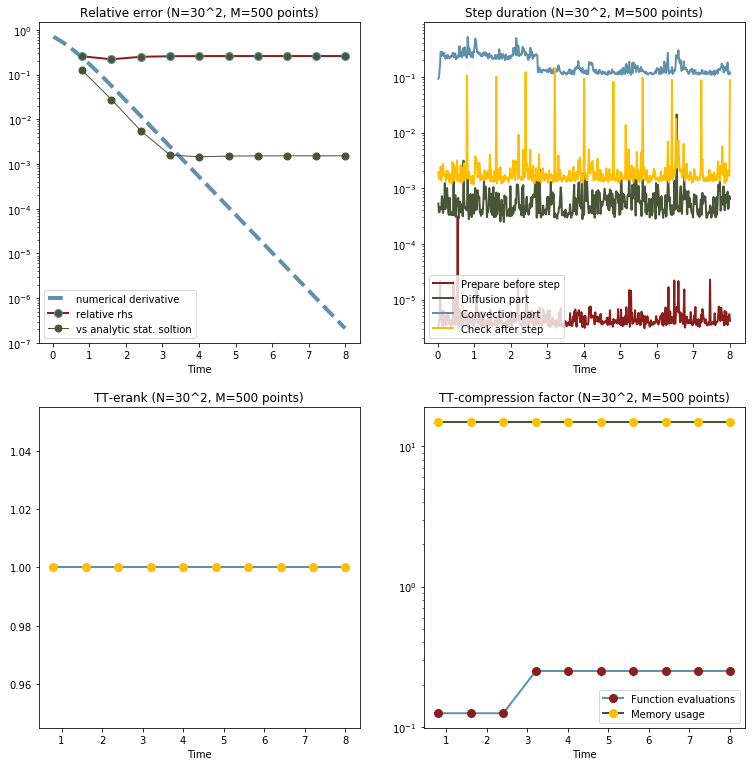

In [3]:
SL.plot()

<div class="end"></div>